In [16]:
#%env PATH=/usr/local/cuda-11.5/bin:/usr/bin:$PATH
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from pinns.prelude import *
from pinns.domain import Sphere
from pinns.calc import laplace, divergence
from scipy.stats.qmc import Sobol
from pinns.model import mlp
from pinns.opt import train_nn
from pinns.integrate import integrate, midpoint, gauss2

import itertools
import numpy as np
import matplotlib.pyplot as plt
from jax.config import config


In [18]:
domain = Sphere(1., (0., 0., 0.))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(8))
x_bnd = domain.transform_bnd(x_bnd)


In [19]:
def plot_result(sol, ax):
    plt.sca(ax)
    N = 200
    x = np.linspace(-1, 1, N)
    z = np.linspace(-1, 1, N)
    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([1]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))
    phi[np.linalg.norm(X, axis=-1) > 1.] = np.nan

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("autumn"), alpha=0.5)
    plt.colorbar(p)


def plot_model(model):
    fig = plt.figure(figsize=(8, 3))
    ax1, ax2 = fig.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    plot_result(model, ax1)
    ax1.set_title("Model")    
    plot_result(lambda x: abs(model(x) - norm(x, axis=-1) + 1), ax2)
    ax2.set_title("Absolute error")
    


In [20]:
weights = array(Sobol(4, seed=12345).random_base2(8))
W_elm = (weights[:, :3] * 2 - 1)
b_elm = (weights[:, 3] * 2 - 1)

def unit_vec(x):
    return x / norm(x, axis=-1, keepdims=True)

m = lambda x: x / norm(x)
f = lambda x: -divergence(m)(x)
l = lambda x: (1 - norm(x) ** 2)
n = lambda x: unit_vec(-grad(l)(x))
h = lambda x: tanh(W_elm @ x + b_elm)
u = lambda x: l(x) * h(x)
g1 = lambda x: 0.


def test_fun(x, x0, r):
    s = norm(x - x0, axis=-1) / r
    return where(
        s >= 1., 
        0, 
        1 - 6 * s ** 2 + 8 * s ** 3 - 3 * s ** 4
    )

In [21]:
from pinns.integrate import integrate_sphere, gauss5


def integrate_sample(x, r):
    def integrand(x, x0, r):
        return jacfwd(u)(x) @ grad(test_fun)(x, x0, r)
    return integrate_sphere(
        integrand, r, x, 3, x, r, method=gauss5
    )

@jit
def integrate_samples(x, radii):
    return vmap(integrate_sample)(x, radii)


def integrate_source(x, r):
    def integrand(x, x0, r):
        return f(x) * test_fun(x, x0, r)
    return integrate_sphere(
        integrand, r, x, 3, x, r, method=gauss5
    )

@jit
def integrate_sources(x, radii):
    return vmap(integrate_source)(x, radii)



In [22]:
rmax = 0.01
def test_fun_radius(x):
    rmin = 1.0 - norm(x)
    return minimum(rmin, rmax)

radii = vmap(test_fun_radius)(x_dom)

In [23]:
from jaxopt.linear_solve import solve_normal_cg
A = integrate_samples(x_dom, radii)
b = integrate_sources(x_dom, radii)
params_phi1 = solve_normal_cg(lambda x: A @ x, b, init=zeros(A.shape[-1],))

phi1 = lambda x: u(x) @ params_phi1

In [24]:
def phi2_solution(x, x_bnd):
    eps = 1e-7
    def g(y):
        return dot(m(y), n(y)) - dot(grad(phi1)(y), n(y))
    
    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)
    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return (4 * pi * 1. ** 2) / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

In [25]:
_x_bnd = array(Sobol(2, seed=123).random_base2(14))
_x_bnd = domain.transform_bnd(_x_bnd)
phi_bnd = phi2_solution(x_bnd, _x_bnd)

In [26]:
from pinns.elm import elm

g2 = elm(x_bnd, phi_bnd, W_elm, b_elm, ridge=0.00001)


def integrate_bnd(x, r):
    def integrand(x, x0, r):
        return grad(g2)(x) @ grad(test_fun)(x, x0, r)
    return integrate_sphere(
        integrand, r, x, 3, x, r, method=gauss5
    )

@jit
def integrate_bnd_data(x, radii):
    return vmap(integrate_bnd)(x, radii)



b2 = integrate_bnd_data(x_dom, radii)


In [27]:
from jaxopt.linear_solve import solve_normal_cg

params_phi2 = solve_normal_cg(lambda x: A @ x, -b2, init=zeros(A.shape[-1],))

phi2 = lambda x: g2(x) + u(x) @ params_phi2
phi_nn = vmap(lambda x: phi1(x) + phi2(x))

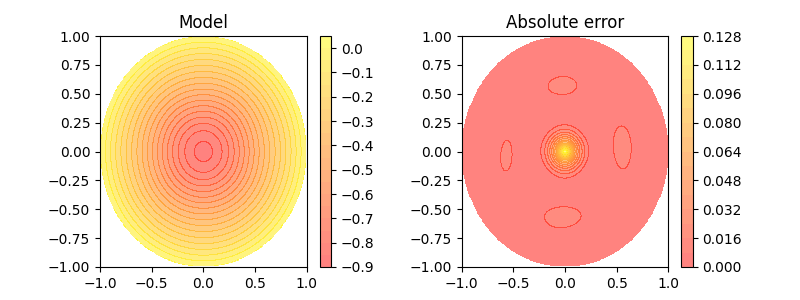

In [28]:
plot_model(phi_nn)

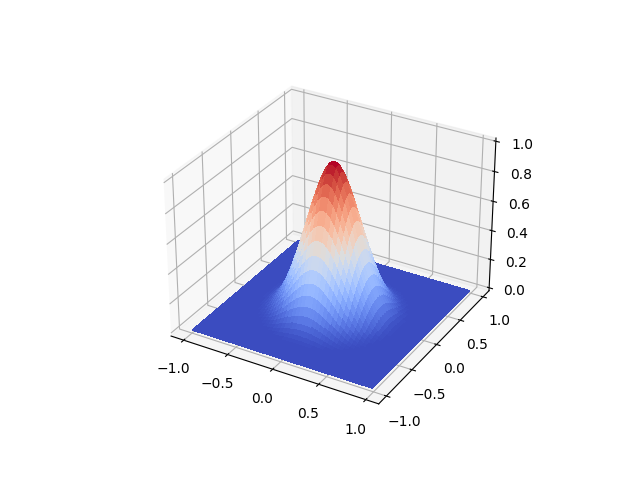

In [29]:
from matplotlib import cm

X = jnp.arange(-1, 1, 0.01)
Y = jnp.arange(-1, 1, 0.01)
X, Y = jnp.meshgrid(X, Y)


Z = test_fun(stack([X, Y], axis=-1), array([0, 0.]), 0.8)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


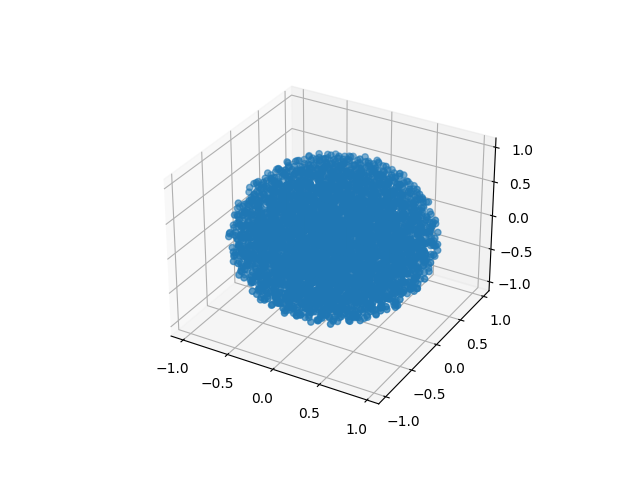

In [30]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter3D(x_dom[:, 0], x_dom[:, 1], x_dom[:, 2])